In [1]:
# Load Data
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

# Download measurement data:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/clinical/measurement.csv')
data_bytes = blob.download_as_bytes()
measurement = pd.read_csv(io.BytesIO(data_bytes))

# Convert measurement from long to wide format: person_id as index, measurement_source_value as columns, and value_source_value as values
measurement_wide = measurement.pivot_table(index='person_id',
                                           columns='measurement_source_value',
                                           values='value_as_number',
                                           aggfunc='first').reset_index()
measurement_wide.columns.name = None  # Remove the name of the columns index
measurement_wide = measurement_wide.rename(columns={'person_id': 'participant_id'})

In [2]:
measurement_wide.head()

,participant_id,A/G Ratio,ALT (IU/L),AST (IU/L),Albumin (g/dL),Alkaline Phosphatase (IU/L),BUN (mg/dL),BUN/Creatinine ratio,"Bilirubin, Total (mg/dL)",C-Peptide (ng/mL),...,"viaosmlog, LLVA Letter Score - Mesopic VA - OS","viaosmscore, Mesopic LogMAR OS Score","viaosmsf, Snellen fraction - Mesopic VA - OS","viaosplog, VA Letter Score - Photopic VA - OS","viaospscore, Photopic LogMAR OS Score","viaospsf, Snellen fraction - Photopic VA - OS","viaossph, OS - Autorefractor - Sphere","waist_vsorres, Waist Circumference (cm)","weight_vsorres, Weight (kilograms)","whr_vsorres, Waist to Hip Ratio (WHR)"
0,1001,2.142857,11.0,17.0,4.5,53.0,19.0,23.170732,0.4,2.328178,...,72.0,0.26,40.0,88.0,-0.06,20.0,-6.50,71.0,57.3,0.731959
1,1002,1.419355,20.0,23.0,4.4,65.0,12.0,15.789474,0.5,3.584227,...,57.0,0.56,80.0,74.0,0.22,32.0,-2.25,107.0,94.1,0.972727
2,1003,1.629630,16.0,15.0,4.4,53.0,16.0,19.512195,0.8,4.162035,...,73.0,0.24,40.0,88.0,-0.06,20.0,-0.75,107.0,73.2,1.038835
3,1004,1.954545,15.0,10.0,4.3,95.0,14.0,19.178082,0.3,1.028293,...,40.0,0.90,160.0,49.0,0.72,100.0,-2.50,91.5,76.8,0.919598
4,1005,1.413793,21.0,22.0,4.1,78.0,15.0,14.423077,0.3,0.673029,...,65.0,0.40,50.0,76.0,0.18,32.0,-0.50,87.0,79.6,0.915789


In [3]:
# Load Mamba Model
# Load Data
import os
import sys

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_576_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

tft = load_tft_from_gcs(model_name="Mamba2_12h_576c_MES", training_dataset=training)
tft.eval()  # Put model in evaluation mode

/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK
[2025-08-25 03:00:11.545682] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Loaded TFT from gs://cgmproject2025/models/predictions/Mamba2_12h_576c_MES/


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

# Obtain Embeddings

In [4]:
# View Embeddings
import numpy as np

#Get embedding for static: participant_id
embedding_name = "participant_id"
embedding_layer = tft.input_embeddings[embedding_name]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# assume embedding_weights is your (participants × emb_dim) array

#Get embedding for static:
participantIDs = np.array(
        list(training.get_parameters()["categorical_encoders"]["participant_id"].classes_)
    )

# 1. compute similarity
similarity_matrix = cosine_similarity(embedding_weights)

# 2. wrap in a DataFrame for labels
sim_df = pd.DataFrame(
    similarity_matrix,
    index=participantIDs,
    columns=participantIDs
)
print(sim_df.head())

          1023      1024      1026      1027      1028      1029      1030  \
1023  1.000000 -0.233543  0.120750  0.146427 -0.061732 -0.169471 -0.138011   
1024 -0.233543  1.000000  0.172107  0.081440 -0.139514 -0.057306  0.178126   
1026  0.120750  0.172107  1.000000 -0.056018 -0.069428 -0.031910  0.027262   
1027  0.146427  0.081440 -0.056018  1.000000 -0.078744 -0.005834 -0.221149   
1028 -0.061732 -0.139514 -0.069428 -0.078744  1.000000 -0.058115  0.270325   

          1031      1032      1033  ...      7398      7399      7401  \
1023 -0.083349  0.054940 -0.166344  ...  0.208621 -0.160754  0.050794   
1024 -0.037188 -0.009399  0.213948  ...  0.072993  0.365529 -0.038369   
1026 -0.040342 -0.207246 -0.080158  ...  0.372654  0.121353 -0.225241   
1027 -0.275427  0.154113  0.208402  ...  0.111553  0.000470  0.046888   
1028  0.121606 -0.083397 -0.148062  ... -0.217676  0.001874 -0.092682   

          7403      7404      7405      7406      7407      7409      7411  
1023  0.282403 

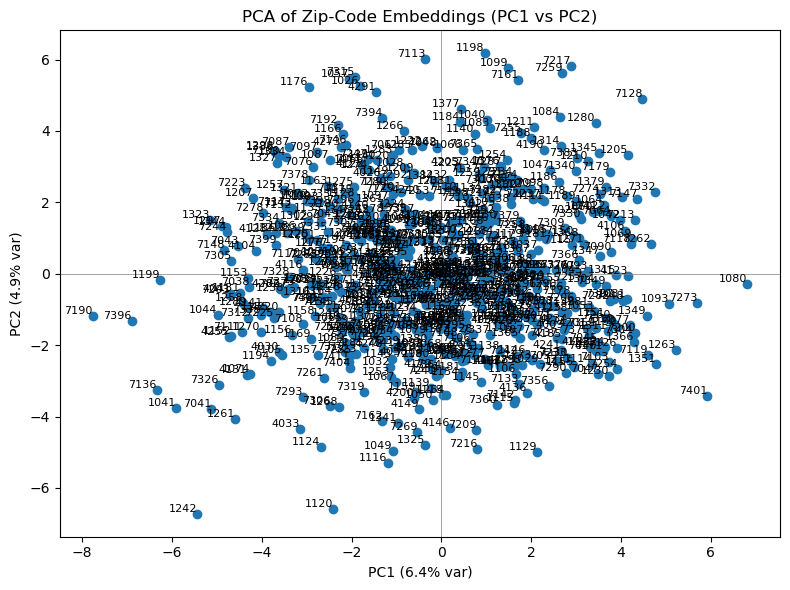

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Run PCA on your embedding_weights matrix (shape: n_zip × emb_dim)
pca = PCA(n_components=2)
pcs = pca.fit_transform(embedding_weights)   # → array shape (n_zip, 2)

# 2. Wrap into a DataFrame with your zip‐code labels
pc_df = pd.DataFrame(
    pcs,
    columns=["PC1", "PC2"],
    index=participantIDs
)

# 3. Plot as a scatter, annotating each point by its zip code
plt.figure(figsize=(8,6))
plt.scatter(pc_df["PC1"], pc_df["PC2"])
for zip_code, (x, y) in pc_df.iterrows():
    plt.text(x, y, zip_code, fontsize=8, ha="right", va="bottom")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.title("PCA of Zip‐Code Embeddings (PC1 vs PC2)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.tight_layout()
plt.show()

# Embeddings for Individual Study Groups

[[ 0.38134778  0.29057187 -1.2153468 ]
 [-1.9858668   0.29307556  1.197878  ]
 [-0.5316778  -1.54939     0.83283144]
 [ 1.9675738  -2.1375566  -0.41247138]]


/tmp/ipykernel_17517/892563300.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ax = sns.heatmap(sim_df, annot=sim_df.applymap(fmt_plus), fmt="", cmap=cmap, center=0,


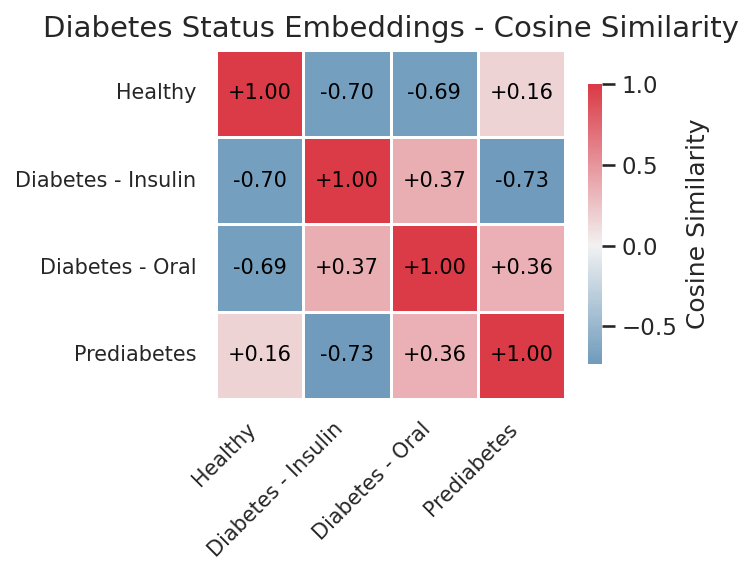

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# assume embedding_weights is your (n_zip × emb_dim) array
# and zip_code_to_idx is a list of your zip codes in the same order

import numpy as np
#Get embedding for static:
studyIDs = np.array(
        list(training.get_parameters()["categorical_encoders"]["study_group"].classes_)
    )

embedding_name = "study_group"
embedding_layer = tft.input_embeddings[embedding_name]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()
print(embedding_weights)

# 1. compute similarity
similarity_matrix = cosine_similarity(embedding_weights)

# 2. wrap in a DataFrame for labels
sim_df = pd.DataFrame(
    similarity_matrix,
    index=studyIDs,
    columns=studyIDs
)

# Name the study groups appropriately
study_group_names = {
    "healthy": "Healthy",
    "insulin_dependent": "Diabetes - Insulin",
    "oral_medication_and_or_non_insulin_injectable_medication_controlled": "Diabetes - Oral",
    "pre_diabetes_lifestyle_controlled": "Prediabetes"
}
sim_df.rename(index=study_group_names, columns=study_group_names, inplace=True)


# Make a Nature-quality heatmap
plt.figure(figsize=(5, 4))
sns.set_theme(style="white")

# Use a diverging colormap suitable for similarities (-1 to 1)
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Custom formatter to show "+" for positive values
def fmt_plus(x):
    return f"+{x:.2f}" if x > 0 else f"{x:.2f}"

ax = sns.heatmap(sim_df, annot=sim_df.applymap(fmt_plus), fmt="", cmap=cmap, center=0,
                 square=True, linewidths=0.5, cbar_kws={"shrink": .8, "label": "Cosine Similarity"},
                 annot_kws={"size": 10, "color": "black"})

plt.title("Diabetes Status Embeddings - Cosine Similarity", fontsize=14)
#plt.xlabel("Study Group", fontsize=12)
#plt.ylabel("Study Group", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig("./figures/study_group_embedding_similarity_heatmap.png", dpi=300)
plt.savefig("./figures/study_group_embedding_similarity_heatmap.svg")
# Show plot
plt.show()

In [8]:
# Correlate Individual Embeddings with Clinical Measurements
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
#Get embedding for static:
participantIDs = np.array(
        list(training.get_parameters()["categorical_encoders"]["participant_id"].classes_)
    )
embedding_name = "participant_id"
embedding_layer = tft.input_embeddings[embedding_name]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()

# 1. Run PCA on your embedding_weights matrix (shape: n_participants × emb_dim)
pca = PCA(n_components=10)  # Keep top 10 PCs
pcs = pca.fit_transform(embedding_weights)   # → array shape (n_participants, 10)   
print(f"Explained variance by top 10 PCs: {pca.explained_variance_ratio_}")
# 2. Wrap into a DataFrame with your participant IDs as index
pc_df = pd.DataFrame(
    pcs,
    columns=[f"PC{i+1}" for i in range(pcs.shape[1])],
    index=participantIDs
)

# Convert index to column for merging
pc_df = pc_df.reset_index().rename(columns={"index": "participant_id"})
print(pc_df.head())

# Convert participant_id to int
pc_df["participant_id"] = pc_df["participant_id"].astype(int)
measurement_wide["participant_id"] = measurement_wide["participant_id"].astype(int)


# 3. Merge with clinical measurements
merged_df = pc_df.merge(measurement_wide, on="participant_id", how="left")
merged_df = merged_df.set_index("participant_id")
print(merged_df.head())

# 4. Compute correlations between each PC and each clinical measurement
pc_columns = [f"PC{i+1}" for i in range(pcs.shape[1])]
measurement_columns = [col for col in measurement_wide.columns if col != "participant_id"]
correlation_results = []
for pc in pc_columns:
    for meas in measurement_columns:
        if meas in merged_df.columns:
            valid_data = merged_df[[pc, meas]].dropna()
            if len(valid_data) > 2:  # Need at least 3 points to compute correlation
                corr, pval = pearsonr(valid_data[pc], valid_data[meas])
                correlation_results.append((pc, meas, corr, pval))
# 5. Convert results to DataFrame
corr_df = pd.DataFrame(correlation_results, columns=["PC", "Measurement", "Correlation", "P-value"])
# 6. Display top correlations
top_corrs = corr_df.reindex(corr_df.Correlation.abs().sort_values(ascending=False).index)
print(top_corrs.head(20))   

Explained variance by top 10 PCs: [0.06394077 0.04923187 0.03888248 0.03649409 0.03498258 0.03065142
 0.02796724 0.0247672  0.02303126 0.02030515]
  participant_id       PC1       PC2       PC3       PC4       PC5       PC6  \
0           1023  0.472128 -0.649756 -2.846153 -0.993952 -2.923129  2.915781   
1           1024 -0.696367  0.658028 -0.058328  2.778908 -0.035775 -0.799773   
2           1026 -1.816686  5.258228 -1.870453 -1.362368 -0.572163  1.320089   
3           1027 -0.635915 -1.036146  0.049803  2.142656  0.330026  3.637108   
4           1028 -0.814969  2.973439 -1.277458  0.164542 -0.446364 -2.239440   

        PC7       PC8       PC9      PC10  
0  1.191075  0.058713  0.519758 -1.725051  
1  0.572854 -0.611895 -2.331030  0.506628  
2  0.066688  0.923914 -2.504429 -0.806185  
3  0.896759 -2.814568 -0.074271  0.658392  
4 -2.024871 -2.752008  3.918344  1.008989  
                     PC1       PC2       PC3       PC4       PC5       PC6  \
participant_id                

/tmp/ipykernel_17517/1772773617.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[pc], valid_data[meas])
/tmp/ipykernel_17517/1772773617.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[pc], valid_data[meas])
/tmp/ipykernel_17517/1772773617.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[pc], valid_data[meas])
/tmp/ipykernel_17517/1772773617.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[pc], valid_data[meas])
/tmp/ipykernel_17517/1772773617.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(valid_data[pc], valid_data[meas])
/tmp/ipykernel_17517/1772773617.py:50: Consta

      PC                              Measurement  Correlation       P-value
219  PC2    whr_vsorres, Waist to Hip Ratio (WHR)    -0.191186  1.697120e-07
217  PC2  waist_vsorres, Waist Circumference (cm)    -0.162932  8.647295e-06
126  PC2                  HDL Cholesterol (mg/dL)     0.143224  1.151088e-04
218  PC2       weight_vsorres, Weight (kilograms)    -0.134045  2.554271e-04
347  PC4                                HbA1c (%)    -0.127150  6.323002e-04
455  PC5                          Glucose (mg/dL)     0.120700  1.174662e-03
42   PC1              height_vsorres, Height (cm)     0.118707  1.225050e-03
26   PC1                        Troponin-T (ng/L)     0.113051  2.381943e-03
118  PC2                        C-Peptide (ng/mL)    -0.112480  2.542140e-03
139  PC2                         bmi_vsorres, BMI    -0.109917  2.771166e-03
393  PC4  mlcsoslog, OS: Log Contrast Sensitivity     0.107559  3.505511e-03
459  PC5      LDL Cholesterol Calculation (mg/dL)    -0.107075  4.022223e-03

In [9]:
# Rank the correlations by absolute value
ranked_corrs = corr_df.reindex(corr_df.Correlation.abs().sort_values(ascending=False).index)
print(ranked_corrs.head(20))

      PC                              Measurement  Correlation       P-value
219  PC2    whr_vsorres, Waist to Hip Ratio (WHR)    -0.191186  1.697120e-07
217  PC2  waist_vsorres, Waist Circumference (cm)    -0.162932  8.647295e-06
126  PC2                  HDL Cholesterol (mg/dL)     0.143224  1.151088e-04
218  PC2       weight_vsorres, Weight (kilograms)    -0.134045  2.554271e-04
347  PC4                                HbA1c (%)    -0.127150  6.323002e-04
455  PC5                          Glucose (mg/dL)     0.120700  1.174662e-03
42   PC1              height_vsorres, Height (cm)     0.118707  1.225050e-03
26   PC1                        Troponin-T (ng/L)     0.113051  2.381943e-03
118  PC2                        C-Peptide (ng/mL)    -0.112480  2.542140e-03
139  PC2                         bmi_vsorres, BMI    -0.109917  2.771166e-03
393  PC4  mlcsoslog, OS: Log Contrast Sensitivity     0.107559  3.505511e-03
459  PC5      LDL Cholesterol Calculation (mg/dL)    -0.107075  4.022223e-03

# Use method outside PCA to correlate Embeddings from Mamba to Clinical Features

In [10]:
merged_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,"viaosmlog, LLVA Letter Score - Mesopic VA - OS","viaosmscore, Mesopic LogMAR OS Score","viaosmsf, Snellen fraction - Mesopic VA - OS","viaosplog, VA Letter Score - Photopic VA - OS","viaospscore, Photopic LogMAR OS Score","viaospsf, Snellen fraction - Photopic VA - OS","viaossph, OS - Autorefractor - Sphere","waist_vsorres, Waist Circumference (cm)","weight_vsorres, Weight (kilograms)","whr_vsorres, Waist to Hip Ratio (WHR)"
participant_id,,,,,,,,,,,,,,,,,,,,,
1023,0.472128,-0.649756,-2.846153,-0.993952,-2.923129,2.915781,1.191075,0.058713,0.519758,-1.725051,...,69.0,0.32,40.0,83.0,0.04,25.0,-0.25,117.6,91.7,1.110482
1024,-0.696367,0.658028,-0.058328,2.778908,-0.035775,-0.799773,0.572854,-0.611895,-2.331030,0.506628,...,63.0,0.44,63.0,78.0,0.14,32.0,-2.50,80.1,57.7,0.877327
1026,-1.816686,5.258228,-1.870453,-1.362368,-0.572163,1.320089,0.066688,0.923914,-2.504429,-0.806185,...,43.0,0.84,160.0,54.0,0.62,80.0,1.50,68.6,48.5,0.775141
1027,-0.635915,-1.036146,0.049803,2.142656,0.330026,3.637108,0.896759,-2.814568,-0.074271,0.658392,...,70.0,0.30,40.0,84.0,0.02,20.0,-2.25,103.2,86.6,1.003891
1028,-0.814969,2.973439,-1.277458,0.164542,-0.446364,-2.239440,-2.024871,-2.752008,3.918344,1.008989,...,70.0,0.30,40.0,83.0,0.04,25.0,-0.50,89.8,63.9,0.963519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7405,-2.712405,-0.819938,-0.826912,-0.587105,2.139819,-1.077132,2.628014,0.714319,-0.022444,-1.784608,...,69.0,0.32,40.0,82.0,0.06,25.0,0.00,111.1,98.0,0.970306
7406,1.060268,-0.566854,0.091216,-0.288407,0.980630,2.621815,-0.142676,-1.230852,-1.556790,-1.709374,...,88.0,-0.06,20.0,95.0,-0.20,12.0,-1.50,114.0,90.1,0.982759
7407,0.880797,-0.249215,-2.308758,-0.979739,-1.236089,2.012649,-0.863734,-0.259306,-2.338713,3.290112,...,72.0,0.26,40.0,86.0,-0.02,20.0,-1.75,99.6,80.5,0.966052


In [11]:
merged_df.columns[0:50]

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'A/G Ratio', 'ALT (IU/L)', 'AST (IU/L)', 'Albumin (g/dL)',
       'Alkaline Phosphatase (IU/L)', 'BUN (mg/dL)', 'BUN/Creatinine ratio',
       'Bilirubin, Total (mg/dL)', 'C-Peptide (ng/mL)', 'CRP - HS (mg/L)',
       'Calcium (mg/dL)', 'Carbon Dioxide, Total (mEq/L)', 'Chloride (mEq/L)',
       'Creatinine (mg/dL)', 'Globulin, Total (g/dL)', 'Glucose (mg/dL)',
       'HDL Cholesterol (mg/dL)', 'HbA1c (%)', 'INSULIN (ng/mL)',
       'LDL Cholesterol Calculation (mg/dL)', 'NT-proBNP (pg/mL)',
       'Potassium (mEq/L)', 'Protein, Total (g/dL)', 'Sodium (mEq/L)',
       'Total Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
       'Troponin-T (ng/L)', 'Urine Albumin (mg/dL)',
       'Urine Creatinine (mg/dL)', 'bmi_vsorres, BMI',
       'bp1_diabp_vsorres, Diastolic (mmHg)',
       'bp1_sysbp_vsorres, Systolic (mmHg)',
       'bp2_diabp_vsorres, Diastolic (mmHg)',
       'bp2_sysbp_vsorres, Systolic (mmHg

In [12]:
merged_df.columns[50:100]

Index(['fluency_language', 'fluency_language_time',
       'height_vsorres, Height (cm)', 'hip_vsorres, Hip Circumference (cm)',
       'lbscat_a1c, Hemoglobin - g/dL', 'lbscat_hct, Hematocrit  - %',
       'lbscat_mch, MCH - pg', 'lbscat_mchc, MCHC - g/dL',
       'lbscat_mcv, MCV - fL', 'lbscat_plt, Platelets - x10E3/µL',
       'lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL', 'lbscat_rdw, RDW - %',
       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL', 'lettera',
       'lettera_time', 'memory_trial1', 'memory_trial1_time', 'memory_trial2',
       'memory_trial2_time', 'mlcsodfcl, OD: Value of final correct letter',
       'mlcsodlog, OD: Log Contrast Sensitivity',
       'mlcsodmiss, OD: Number of misses prior to stoppin',
       'mlcsosfcl, OS: Value of final correct letter',
       'mlcsoslog, OS: Log Contrast Sensitivity',
       'mlcsosmiss, OS: Number of misses prior to stoppin', 'moca_abstraction',
       'moca_abstraction_time', 'moca_combined_mis_score', 'moca_orientation'

In [13]:
merged_df.columns[100:150]

Index(['viaodcyl, OD - Autorefractor - Cylinder',
       'viaodmlog, LLVA Letter Score - Mesopic VA - OD',
       'viaodmscore, Mesopic LogMAR OD Score',
       'viaodmsf, Snellen fraction - Mesopic VA - OD',
       'viaodplog, VA Letter Score - Photopic VA - OD',
       'viaodpscore, Photopic LogMAR OD Score',
       'viaodpsf, Snellen fraction - Photopic VA - OD',
       'viaodsph, OD - Autorefractor - Sphere',
       'viaosaxi, OS - Autorefractor - Axis',
       'viaoscyl, OS - Autorefractor - Cylinder',
       'viaosmlog, LLVA Letter Score - Mesopic VA - OS',
       'viaosmscore, Mesopic LogMAR OS Score',
       'viaosmsf, Snellen fraction - Mesopic VA - OS',
       'viaosplog, VA Letter Score - Photopic VA - OS',
       'viaospscore, Photopic LogMAR OS Score',
       'viaospsf, Snellen fraction - Photopic VA - OS',
       'viaossph, OS - Autorefractor - Sphere',
       'waist_vsorres, Waist Circumference (cm)',
       'weight_vsorres, Weight (kilograms)',
       'whr_vsorres, Wais

In [14]:
embedding_weights

array([[ 0.28020477, -0.8697125 , -1.7588245 , ..., -2.0496073 ,
         0.6086682 ,  0.7282227 ],
       [-0.03293337, -0.28156045, -0.64504606, ...,  1.3844457 ,
        -2.3461256 ,  0.94618344],
       [ 2.3018527 ,  0.4384806 ,  0.04402286, ..., -0.20287022,
        -2.1720433 ,  0.17393114],
       ...,
       [ 0.65111935,  0.263447  , -0.61074656, ..., -0.08909241,
        -0.50942683,  1.1069943 ],
       [-1.506999  , -0.80418605,  0.4864831 , ..., -1.3595119 ,
         1.1580535 ,  0.66046625],
       [ 0.8518581 ,  1.90954   ,  0.63932157, ...,  1.5360525 ,
        -0.06275566,  2.5847785 ]], shape=(741, 65), dtype=float32)

In [15]:
# Find what this column is: lbscat_hct, Hematocrit  - %. And why it is not working:
# It is a clinical measurement of hematocrit percentage, which indicates the proportion of red blood cells in the blood.
# It might not be working because it has many missing values or is not properly aligned with participant IDs.
#merged_df['lbscat_hct, Hematocrit  - %']

In [16]:
lab_names = ['A/G Ratio', 'ALT (IU/L)', 'AST (IU/L)', 'Albumin (g/dL)',
       'Alkaline Phosphatase (IU/L)', 'BUN (mg/dL)', 'BUN/Creatinine ratio',
       'Bilirubin, Total (mg/dL)', 'C-Peptide (ng/mL)', 'CRP - HS (mg/L)',
       'Calcium (mg/dL)', 'Carbon Dioxide, Total (mEq/L)', 'Chloride (mEq/L)',
       'Creatinine (mg/dL)', 'Globulin, Total (g/dL)', 'Glucose (mg/dL)',
       'HDL Cholesterol (mg/dL)', 'HbA1c (%)', 'INSULIN (ng/mL)',
       'LDL Cholesterol Calculation (mg/dL)', 'NT-proBNP (pg/mL)',
       'Potassium (mEq/L)', 'Protein, Total (g/dL)', 'Sodium (mEq/L)',
       'Total Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
       'Troponin-T (ng/L)', 'Urine Albumin (mg/dL)',
       'Urine Creatinine (mg/dL)', 'bmi_vsorres, BMI',
       'bp1_diabp_vsorres, Diastolic (mmHg)',
       'bp1_sysbp_vsorres, Systolic (mmHg)',
       'bp2_diabp_vsorres, Diastolic (mmHg)',
       'bp2_sysbp_vsorres, Systolic (mmHg)',
       'height_vsorres, Height (cm)', 'hip_vsorres, Hip Circumference (cm)',
       'lbscat_a1c, Hemoglobin - g/dL', #'lbscat_hct, Hematocrit  - %',
       'lbscat_mch, MCH - pg', 'lbscat_mchc, MCHC - g/dL',
       'lbscat_mcv, MCV - fL', 'lbscat_plt, Platelets - x10E3/µL',
       'lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL', 'lbscat_rdw, RDW - %',
       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
       'pulse_vsorres, Heart Rate (bpm)', 'pulse_vsorres_2, Heart Rate (bpm)',
       'waist_vsorres, Waist Circumference (cm)',
       'weight_vsorres, Weight (kilograms)',
       'whr_vsorres, Waist to Hip Ratio (WHR)']
Y = merged_df[lab_names].values  # (n_subjects, k_labs)
print(Y)
print(Y.shape)

[[  2.33333333  37.          23.         ... 117.6         91.7
    1.11048159]
 [  1.76923077   9.          15.         ...  80.1         57.7
    0.87732749]
 [  1.90909091  12.          16.         ...  68.6         48.5
    0.77514124]
 ...
 [  1.53571429  14.          15.         ...  99.6         80.5
    0.96605238]
 [  1.84        25.          17.         ...  91.8         92.1
    0.82479784]
 [  1.70833333  21.          16.         ... 122.1        103.5
    0.99107143]]
(741, 49)


In [19]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import umap
import seaborn as sns

sns.set_context("paper")
plt.rcParams.update({"figure.dpi": 150})

def residualize(X, C):
    if C is None: return X
    lr = LinearRegression().fit(C, X)
    return X - lr.predict(C)

In [20]:
# Inputs:
# Z: (n_subjects, d_embed) embeddings
# Y: (n_subjects, k_labs) clinical labs (continuous)
# C: (n_subjects, c_cov) covariates (e.g., age/sex/BMI), or None

Z = embedding_weights  # (n_subjects, d_embed)
lab_names = ['A/G Ratio', 'ALT (IU/L)', 'AST (IU/L)', 'Albumin (g/dL)',
       'Alkaline Phosphatase (IU/L)', 'BUN (mg/dL)', 'BUN/Creatinine ratio',
       'Bilirubin, Total (mg/dL)', 'C-Peptide (ng/mL)', 'CRP - HS (mg/L)',
       'Calcium (mg/dL)', 'Carbon Dioxide, Total (mEq/L)', 'Chloride (mEq/L)',
       'Creatinine (mg/dL)', 'Globulin, Total (g/dL)', 'Glucose (mg/dL)',
       'HDL Cholesterol (mg/dL)', 'HbA1c (%)', 'INSULIN (ng/mL)',
       'LDL Cholesterol Calculation (mg/dL)', 'NT-proBNP (pg/mL)',
       'Potassium (mEq/L)', 'Protein, Total (g/dL)', 'Sodium (mEq/L)',
       'Total Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
       'Troponin-T (ng/L)', 'Urine Albumin (mg/dL)',
       'Urine Creatinine (mg/dL)', 'bmi_vsorres, BMI',
       'bp1_diabp_vsorres, Diastolic (mmHg)',
       'bp1_sysbp_vsorres, Systolic (mmHg)',
       'bp2_diabp_vsorres, Diastolic (mmHg)',
       'bp2_sysbp_vsorres, Systolic (mmHg)',
       'height_vsorres, Height (cm)', 'hip_vsorres, Hip Circumference (cm)',
       'lbscat_a1c, Hemoglobin - g/dL', #'lbscat_hct, Hematocrit  - %',
       'lbscat_mch, MCH - pg', 'lbscat_mchc, MCHC - g/dL',
       'lbscat_mcv, MCV - fL', 'lbscat_plt, Platelets - x10E3/µL',
       'lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL', 'lbscat_rdw, RDW - %',
       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
       'pulse_vsorres, Heart Rate (bpm)', 'pulse_vsorres_2, Heart Rate (bpm)',
       'waist_vsorres, Waist Circumference (cm)',
       'weight_vsorres, Weight (kilograms)',
       'whr_vsorres, Waist to Hip Ratio (WHR)']
Y = merged_df[lab_names].values  # (n_subjects, k_labs)
C = None

# Merge X and Y to keep only subjects with both
mask = np.isfinite(Z).all(axis=1) & np.isfinite(Y).all(axis=1)
if C is not None:
    mask &= np.isfinite(C).all(axis=1)
Z, Y = Z[mask], Y[mask]
if C is not None:
    C = C[mask]
print(Z.shape, Y.shape, None if C is None else C.shape)


def residualize(X, C):
    if C is None: return X
    lr = LinearRegression().fit(C, X)
    return X - lr.predict(C)

# --- prep ---
Z = StandardScaler().fit_transform(Z)
Y = StandardScaler().fit_transform(Y)
if C is not None:
    C_std = StandardScaler().fit_transform(C)
    Zr = residualize(Z, C_std)
    Yr = residualize(Y, C_std)
else:
    Zr, Yr = Z, Y


(707, 65) (707, 49) None


# 10k permutations for rigor of CCA

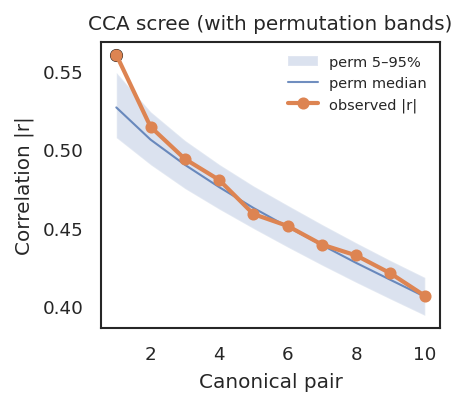

In [ ]:
# Inputs ready from your code:
# Zr: (n, d) standardized (and optionally residualized) embeddings
# Yr: (n, k) standardized (and optionally residualized) labs
# lab_names: list[str] length k
# U: (n, 2) existing UMAP coords of Zr; if you don't have it yet, compute below.

K = min(10, Zr.shape[1], Yr.shape[1])  # examine up to 10 canonical pairs
cca = CCA(n_components=K, max_iter=2000, tol=1e-06, scale=False)
Zc, Yc = cca.fit_transform(Zr, Yr)  # canonical variate scores

# Canonical correlations
can_corrs = np.array([np.corrcoef(Zc[:,i], Yc[:,i])[0,1] for i in range(K)])

# Permutation test for the whole scree (label-shuffle Y)
def perm_scree(Zr, Yr, K, iters=1000, seed=0):
    rng = np.random.default_rng(seed)
    scree = np.zeros((iters, K))
    model = CCA(n_components=K, max_iter=2000, tol=1e-06, scale=False)
    for b in range(iters):
        perm = rng.permutation(Yr.shape[0])
        Zcp, Ycp = model.fit_transform(Zr, Yr[perm])
        scree[b] = [np.corrcoef(Zcp[:,i], Ycp[:,i])[0,1] for i in range(K)]
    return np.abs(scree)

perm = perm_scree(Zr, Yr, K, iters=10000)
pvals_scree = np.mean(np.abs(perm) >= np.abs(can_corrs), axis=0)

# Plot scree with permutation bands
plt.figure(figsize=(3.2, 2.8))
q05, q50, q95 = np.quantile(np.abs(perm), [0.05, 0.5, 0.95], axis=0)
x = np.arange(1, K+1)
plt.fill_between(x, q05, q95, alpha=0.2, label='perm 5–95%')
plt.plot(x, q50, lw=1, alpha=0.8, label='perm median')
plt.plot(x, np.abs(can_corrs), marker='o', lw=2, label='observed |r|')
for i, p in enumerate(pvals_scree):
    if p < 0.05: plt.scatter(i+1, np.abs(can_corrs[i]), s=30, edgecolor='k')
plt.xlabel('Canonical pair'); plt.ylabel('Correlation |r|')
plt.title('CCA scree (with permutation bands)')
plt.legend(fontsize=7, frameon=False); 
plt.tight_layout(); 
plt.savefig("./figures/CCA_scree_with_permutation_bands_n10000.png", dpi=300, bbox_inches="tight")
plt.savefig("./figures/CCA_scree_with_permutation_bands_n10000.svg", bbox_inches="tight")
plt.show()


In [30]:
# # Compute Spearman rho between each lab column and each canonical variate (Yc)
# R = np.zeros((len(lab_names), K))
# P = np.zeros_like(R)
# for j in range(len(lab_names)):
#     yj = Yr[:, j]
#     for i in range(K):
#         rho, p = spearmanr(yj, Yc[:, i])
#         R[j, i] = rho; P[j, i] = p

# # FDR across all lab×CV tests
# rej, qvals, _, _ = multipletests(P.ravel(), alpha=0.05, method='fdr_bh')
# Q = qvals.reshape(P.shape)

# # Order labs by their best-aligned CV (max |rho|)
# order = np.argsort(-np.abs(R).max(axis=1))
# R_sorted, Q_sorted = R[order], Q[order]
# labs_sorted = [lab_names[i] for i in order]

# plt.figure(figsize=(6.8, max(2.6, 0.18*len(labs_sorted))))
# ax = sns.heatmap(R_sorted, cmap='coolwarm', center=0, vmin=-0.5, vmax=0.5,
#                  cbar_kws={'label':'Spearman ρ'}, yticklabels=labs_sorted,
#                  xticklabels=[f'CV{i+1}' for i in range(K)])
# # mark FDR-significant cells
# sig_y, sig_x = np.where(Q_sorted < 0.05)
# ax.scatter(sig_x + 0.5, sig_y + 0.5, s=10, color='k')
# plt.title('Lab × CCA canonical‑variate correlations (Spearman, FDR marked)')
# plt.tight_layout(); plt.show()


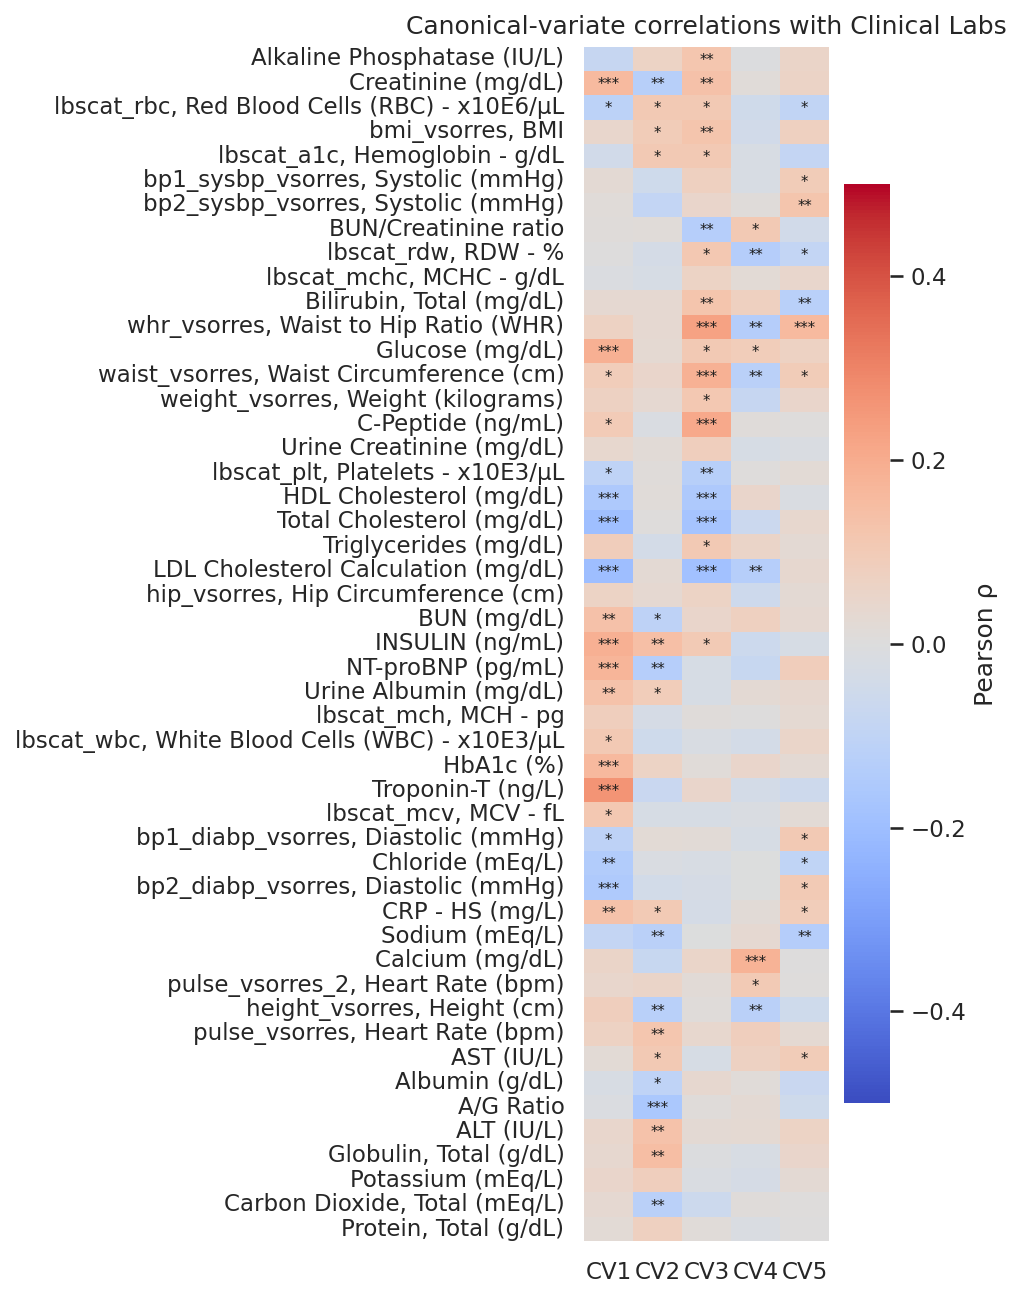

In [93]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

def lab_cv_cor_heatmap(
    Yr, Yc, lab_names, K, method='pearson',
    cluster_rows=False,
    cluster_on='abs',              # 'abs' or 'raw'
    linkage_method='average',      # 'average', 'ward', 'complete', ...
    distance_metric='correlation', # 'correlation' (default) falls back to 'euclidean' if needed
    vmin=-0.5, vmax=0.5
):
    """
    Yr: (n, L) standardized labs (optionally residualized)
    Yc: (n, K) CCA canonical variate scores (Y-side) or Z-side
    lab_names: list of L lab labels
    K: number of canonical pairs to display
    method: 'pearson' or 'spearman'
    cluster_rows: whether to hierarchically cluster the rows (labs)
    cluster_on: 'abs' to cluster on |rho|, or 'raw' to use signed rho
    linkage_method: linkage rule for hierarchical clustering
    distance_metric: base distance metric for pdist; attempts this first
    vmin, vmax: color scale limits for the heatmap
    """
    Yc = Yc[:, :K]  # only keep first K canonical variates
    L = Yr.shape[1]
    R = np.zeros((L, K))
    P = np.zeros_like(R)

    corr_fn = pearsonr if method == 'pearson' else spearmanr

    for j in range(L):
        yj = Yr[:, j]
        for i in range(K):
            rho, p = corr_fn(yj, Yc[:, i])
            R[j, i] = rho; P[j, i] = p

    # FDR across all tests
    _, qvals, _, _ = multipletests(P.ravel(), alpha=0.05, method='fdr_bh')
    Q = qvals.reshape(P.shape)

    # Row ordering: either hierarchical clustering or best-|rho| sort
    if cluster_rows and L > 1:
        X = np.abs(R) if cluster_on == 'abs' else R
        # Try preferred metric; if it yields NaNs (e.g., constant rows with correlation),
        # fall back to euclidean.
        try:
            d = pdist(X, metric=distance_metric)
            if np.any(np.isnan(d)):
                raise ValueError("NaNs in distance vector")
        except Exception:
            d = pdist(X, metric='euclidean')
        Z = linkage(d, method=linkage_method)
        order = leaves_list(Z)
    else:
        order = np.argsort(-np.abs(R).max(axis=1))

    R_sorted, Q_sorted = R[order], Q[order]
    labs_sorted = [lab_names[i] for i in order]

    # Heatmap
    plt.figure(figsize=(6.5, max(2.6, 0.18*len(labs_sorted))))
    ax = sns.heatmap(
        R_sorted, cmap='coolwarm', center=0, vmin=vmin, vmax=vmax,
        cbar_kws={'label': f'{method.title()} ρ'},
        yticklabels=labs_sorted, xticklabels=[f'CV{i+1}' for i in range(K)]
    )
    #plt.title(
    #    f'CCA canonical-variate correlations with Lab Values '
    #    f'({method.title()}, FDR stars'
    #    + (', row-clustered' if cluster_rows else '') + ')'
    #)
    plt.title('Canonical‑variate correlations with Clinical Labs')

    # Add significance stars by q-value thresholds
    # ***: q<0.001, **: q<0.01, *: q<0.05
    for r in range(R_sorted.shape[0]):
        for c in range(R_sorted.shape[1]):
            q = Q_sorted[r, c]
            if q < 0.001: star = '***'
            elif q < 0.01: star = '**'
            elif q < 0.05: star = '*'
            else: star = ''
            if star:
                ax.text(c + 0.5, r + 0.5, star,
                        ha='center', va='center', color='k', fontsize=7)

    plt.tight_layout()
    plt.savefig("./figures/lab_cv_correlation_heatmap.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/lab_cv_correlation_heatmap.svg", bbox_inches="tight")
    plt.show()

    return R, P, Q, order

# --- example usage (keeps your original call but clusters rows by |rho|) ---
# R, P, Q, order = lab_cv_cor_heatmap(Yr, Yc, lab_names, K, method='pearson', cluster_rows=True, cluster_on='abs')
R, P, Q, order = lab_cv_cor_heatmap(Yr, Zc, lab_names, K=5, method='pearson', cluster_rows=True, cluster_on='abs')


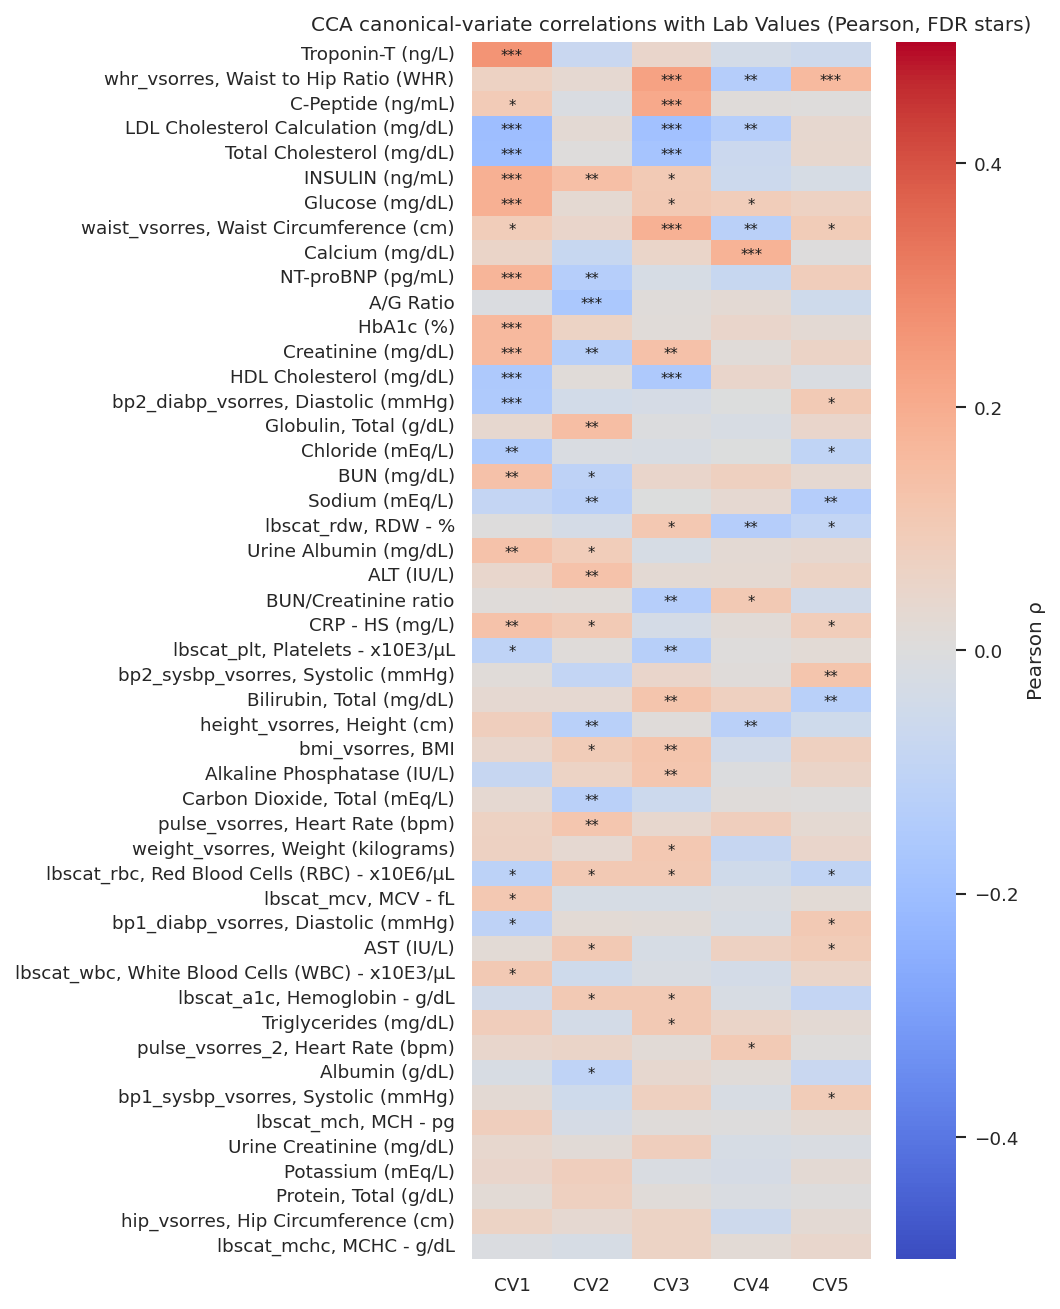

In [ ]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests

def lab_cv_cor_heatmap(Yr, Yc, lab_names, K, method='pearson'):
    """
    Yr: (n, L) standardized labs (optionally residualized)
    Yc: (n, K) CCA canonical variate scores (Y-side) or Z-side; your choice
    lab_names: list of L lab labels
    K: number of canonical pairs to display
    method: 'pearson' or 'spearman'
    """
    Yc = Yc[:, :K]  # only keep first K canonical variates
    L = Yr.shape[1]
    R = np.zeros((L, K))
    P = np.zeros_like(R)

    corr_fn = pearsonr if method == 'pearson' else spearmanr

    for j in range(L):
        yj = Yr[:, j]
        for i in range(K):
            rho, p = corr_fn(yj, Yc[:, i])
            R[j, i] = rho; P[j, i] = p

    # FDR across all tests
    _, qvals, _, _ = multipletests(P.ravel(), alpha=0.05, method='fdr_bh')
    Q = qvals.reshape(P.shape)

    # Order labs by their best |rho|
    order = np.argsort(-np.abs(R).max(axis=1))
    R_sorted, Q_sorted = R[order], Q[order]
    labs_sorted = [lab_names[i] for i in order]

    # Heatmap
    plt.figure(figsize=(6.8, max(2.6, 0.18*len(labs_sorted))))
    ax = sns.heatmap(
        R_sorted, cmap='coolwarm', center=0, vmin=-0.5, vmax=0.5,
        cbar_kws={'label': f'{method.title()} ρ'},
        yticklabels=labs_sorted, xticklabels=[f'CV{i+1}' for i in range(K)]
    )
    plt.title(f'CCA canonical‑variate correlations with Lab Values ({method.title()}, FDR stars)')

    # Add significance stars by q-value thresholds
    # ***: q<0.001, **: q<0.01, *: q<0.05
    for r in range(R_sorted.shape[0]):
        for c in range(R_sorted.shape[1]):
            q = Q_sorted[r, c]
            star = ''
            if q < 0.001: star = '***'
            elif q < 0.01: star = '**'
            elif q < 0.05: star = '*'
            if star:
                ax.text(c + 0.5, r + 0.5, star,
                        ha='center', va='center', color='k', fontsize=7)

    plt.tight_layout(); 
    plt.savefig("./figures/lab_cv_correlation_heatmap.png", dpi=300, bbox_inches="tight")
    plt.savefig("./figures/lab_cv_correlation_heatmap.svg", bbox_inches="tight")
    plt.show()

    return R, P, Q, order #R_sorted, P, Q_sorted, order

# --- call it (choose method='pearson' for consistency with your counterfactuals) ---
#R, P, Q, order = lab_cv_cor_heatmap(Yr, Yc, lab_names, K, method='pearson') ## LAB Defined Latent Space -- Correlationw ith Values
R, P, Q, order = lab_cv_cor_heatmap(Yr, Zc, lab_names, K = 5, method='pearson') ## EMBEDDING Defined Latent Space -- Correlationw ith Values

[-5.29331476e-02  9.48748905e-02  1.47463423e-02 -1.11291602e-01
  4.03760108e-02 -1.02932657e-01  6.50055156e-02  3.66813352e-02
 -8.78129318e-02  3.68216519e-02  3.74194354e-03 -1.39698083e-01
 -2.92468317e-02 -2.97973056e-02  4.08127759e-02 -8.56175199e-02
 -2.85245972e-02  2.19354895e-02  1.22974804e-01 -1.10547730e-01
 -8.26450030e-02  7.10791180e-02 -2.81504589e-02 -2.43282226e-02
  1.54021224e-01 -1.42551289e-01 -3.23014709e-03  4.29678037e-02
 -1.65494996e-02  3.27833443e-01  9.30510981e-02 -8.14797839e-03
 -8.14892507e-02 -4.72267118e-02  2.21823131e-04 -5.13406511e-01
  2.15270435e-01  7.37752960e-02 -1.14443392e-01 -1.28741664e-01
 -1.99294295e-02 -7.46654601e-02 -3.02120101e-02 -8.09794174e-02
  2.68533597e-01 -1.98782102e-01  4.00294870e-01 -1.99057694e-01
 -1.87995355e-01]
[-5.29331476e-02  9.48748905e-02  1.47463423e-02 -1.11291602e-01
  4.03760108e-02 -1.02932657e-01  6.50055156e-02  3.66813352e-02
 -8.78129318e-02  3.68216519e-02  3.74194354e-03 -1.39698083e-01
 -2.924

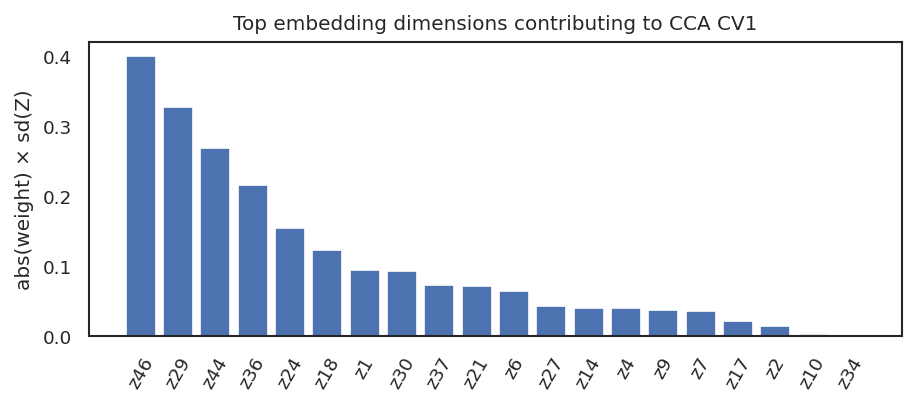

In [ ]:
# Get Feature Importances from CCA:
xw = cca.y_weights_[:, 1]  # weights for CV1 on embedding dims
print(xw)

# Optional variance scaling to reflect contribution in standardized space:
#scale_Y = Yr.std(axis=0, ddof=1)
#importance = np.abs(xw * scale_Y)
importance = np.abs(xw)
print(importance)


topk = 20
idx = np.argsort(-importance)[:topk]
plt.figure(figsize=(6.2, 2.8))
plt.bar(range(topk), importance[idx])
plt.xticks(range(topk), [f'z{t}' for t in idx], rotation=60)
plt.ylabel('abs(weight) × sd(Z)')
plt.title('Top embedding dimensions contributing to CCA CV1')
plt.tight_layout(); plt.show()

In [75]:
lab_names[24]

'Total Cholesterol (mg/dL)'

In [39]:
Y

array([[ 2.46221217,  1.26795161,  0.40362974, ...,  0.8777915 ,
         0.26460024,  2.166337  ],
       [ 0.47329982, -0.99762923, -0.66766534, ..., -1.2275502 ,
        -1.19400355, -0.38956215],
       [ 0.96641858, -0.75488842, -0.53375346, ..., -1.87318832,
        -1.58868458, -1.50975585],
       ...,
       [-0.35003241, -0.59306122, -0.66766534, ..., -0.13277252,
        -0.21588101,  0.58306438],
       [ 0.72281791,  0.2969884 , -0.39984157, ..., -0.57068359,
         0.28176029, -0.96540657],
       [ 0.25858769, -0.02666601, -0.53375346, ...,  1.1304325 ,
         0.77082156,  0.85733009]], shape=(707, 49))

In [36]:
lab_names[38]

'lbscat_mchc, MCHC - g/dL'

In [133]:
np.abs(R[:,1])

array([0.31745147, 0.2549382 , 0.20942537, 0.19940561, 0.12556559,
       0.20966065, 0.02811579, 0.06453651, 0.02615205, 0.20043608,
       0.14606764, 0.22953015, 0.02412114, 0.2433368 , 0.28664106,
       0.05984505, 0.02839809, 0.12339669, 0.27635517, 0.04621697,
       0.25270908, 0.16109842, 0.14440776, 0.23158737, 0.01464647,
       0.07056601, 0.13758197, 0.17774425, 0.03764375, 0.1893828 ,
       0.04065205, 0.10502791, 0.08352469, 0.17478484, 0.23997756,
       0.06382585, 0.20845133, 0.05699532, 0.04663555, 0.05141589,
       0.02095158, 0.21080444, 0.06407093, 0.10581414, 0.22787685,
       0.11201682, 0.09433186, 0.06271945, 0.06516286])

In [134]:
np.argmax(np.abs(R[:,1])) 

np.int64(0)

In [135]:
order

array([26, 48,  4, 40,  8, 22, 10, 19, 20, 46, 24, 18, 15, 14, 30, 38,  0,
       42, 16, 17, 44,  2, 23, 13,  5, 27, 33, 12, 31,  7, 32,  6, 39,  1,
       45, 34, 37, 29,  3, 28,  9, 11, 47, 41, 25, 36, 43, 21, 35])

In [129]:
order[48]

np.int64(35)

In [136]:
lab_names[0]

'A/G Ratio'

Lab most correlated with CV1: whr_vsorres, Waist to Hip Ratio (WHR) (index 48)


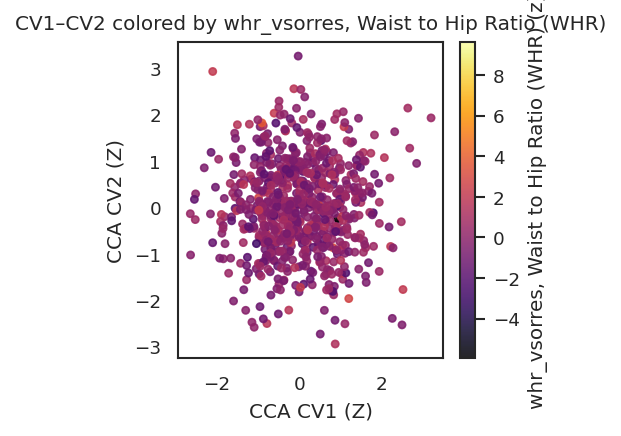

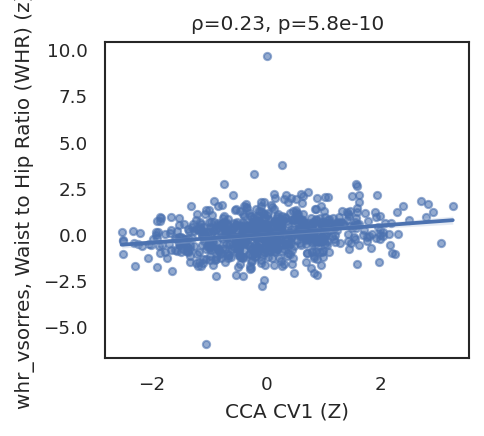

In [146]:
CVdim = 2 # CV1

best_lab_idx = np.argmax(np.abs(R[:,CVdim]))  # lab most correlated with CV1
best_lab = lab_names[best_lab_idx]
print(f"Lab most correlated with CV1: {best_lab} (index {best_lab_idx})")


plt.figure(figsize=(3.2,3.0))
sc = plt.scatter(Zc[:,0], Zc[:,1], c=Yr[:,best_lab_idx], cmap='inferno', s=12, alpha=0.85)
plt.xlabel("CCA CV1 (Z)"); plt.ylabel("CCA CV2 (Z)")
plt.colorbar(sc, label=f"{best_lab} (z)")
plt.title(f"CV1–CV2 colored by {best_lab}")
plt.tight_layout(); plt.show()

# Gradient scatter: CV1 vs lab
import seaborn as sns
plt.figure(figsize=(3.2,3.0))
sns.regplot(x=Zc[:,CVdim], y=Yr[:,best_lab_idx], scatter_kws={'s':12, 'alpha':0.6})
rho, p = pearsonr(Zc[:,CVdim], Yr[:,best_lab_idx])
plt.xlabel("CCA CV1 (Z)"); plt.ylabel(f"{best_lab} (z)")
plt.title(f"ρ={rho:.2f}, p={p:.1e}")
plt.tight_layout(); plt.show()


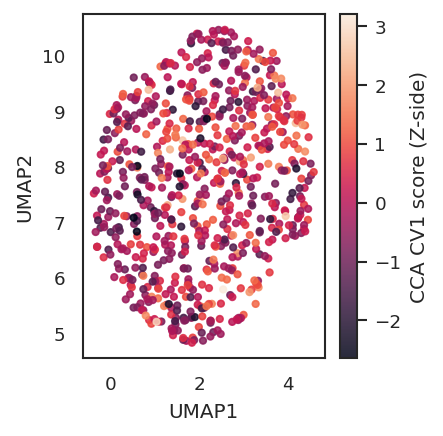

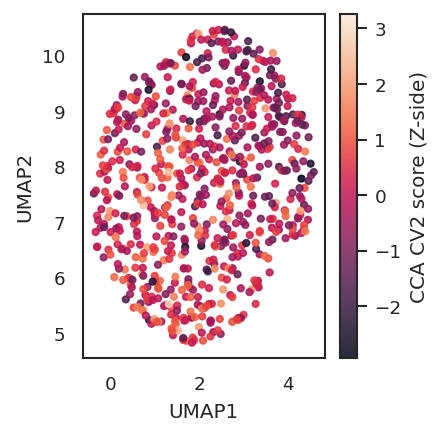

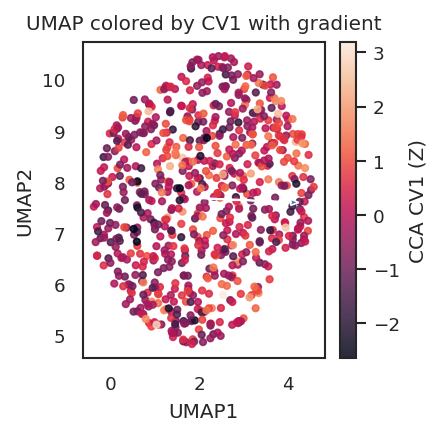

In [61]:
# If you don't already have U (UMAP of Zr), compute it:
if 'U' not in locals():
    um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=0)
    U = um.fit_transform(Zr)

def umap_color_by(values, title):
    plt.figure(figsize=(3.0, 3.0))
    sc = plt.scatter(U[:,0], U[:,1], c=values, s=10, alpha=0.85)
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
    cbar = plt.colorbar(sc); cbar.set_label(title)
    plt.tight_layout(); plt.show()

# Color by CV1 (embedding side) and CV2
umap_color_by(Zc[:,0], 'CCA CV1 score (Z-side)')
umap_color_by(Zc[:,1], 'CCA CV2 score (Z-side)')

# Optional: add a small arrow indicating the local gradient direction of CV1 in UMAP
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(U, Zc[:,0])
vec = lr.coef_ / np.linalg.norm(lr.coef_)
center = U.mean(axis=0)
plt.figure(figsize=(3.0, 3.0))
sc = plt.scatter(U[:,0], U[:,1], c=Zc[:,0], s=10, alpha=0.85)
plt.arrow(center[0], center[1], 2*vec[0], 2*vec[1], width=0.01, head_width=0.12)
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.colorbar(sc, label='CCA CV1 (Z)'); plt.title('UMAP colored by CV1 with gradient')
plt.tight_layout(); plt.show()


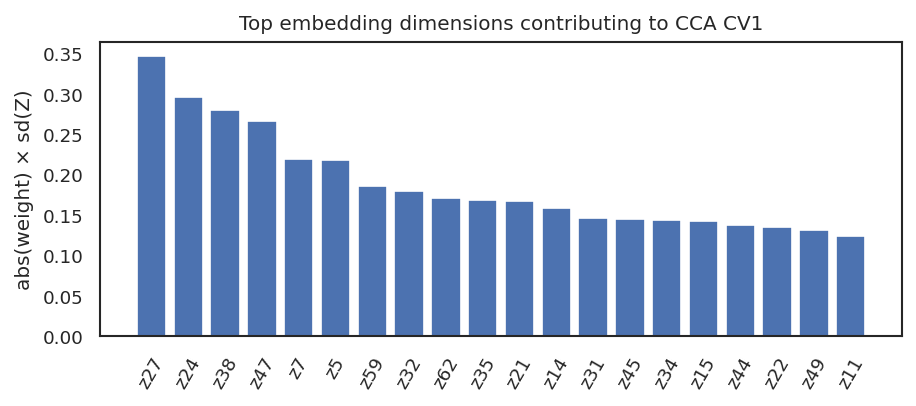

In [62]:
xw = cca.x_weights_[:, 0]  # weights for CV1 on embedding dims
# Optional variance scaling to reflect contribution in standardized space:
scale_Z = Zr.std(axis=0, ddof=1)
importance = np.abs(xw * scale_Z)

topk = 20
idx = np.argsort(-importance)[:topk]
plt.figure(figsize=(6.2, 2.8))
plt.bar(range(topk), importance[idx])
plt.xticks(range(topk), [f'z{t}' for t in idx], rotation=60)
plt.ylabel('abs(weight) × sd(Z)')
plt.title('Top embedding dimensions contributing to CCA CV1')
plt.tight_layout(); plt.show()


Best‑aligned lab with CV1: Total Cholesterol (mg/dL) rho= -0.37814101284768603


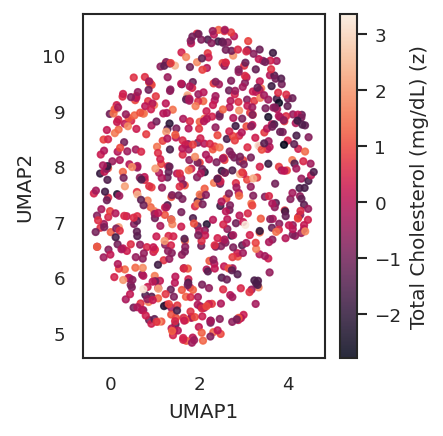

In [63]:
best_lab_idx = np.argmax(np.abs(R[:,0]))
best_lab = lab_names[best_lab_idx]
print("Best‑aligned lab with CV1:", best_lab, "rho=", R[best_lab_idx, 0])

# UMAP colored by that lab for side-by-side comparison
umap_color_by(Yr[:, best_lab_idx], f'{best_lab} (z)')


# TRASH BELOW

(707, 65) (707, 49) None


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/shaksonisaac/m

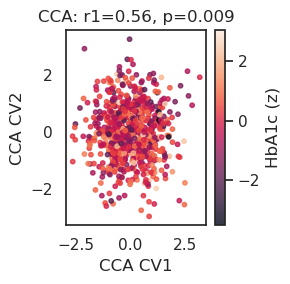

/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


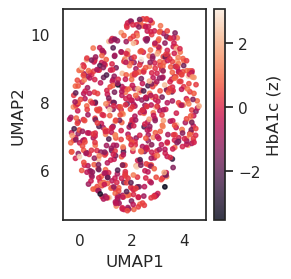

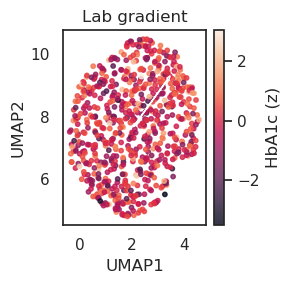

In [ ]:
# CCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import umap
import matplotlib.pyplot as plt

# Inputs:
# Z: (n_subjects, d_embed) embeddings
# Y: (n_subjects, k_labs) clinical labs (continuous)
# C: (n_subjects, c_cov) covariates (e.g., age/sex/BMI), or None

Z = embedding_weights  # (n_subjects, d_embed)
lab_names = ['A/G Ratio', 'ALT (IU/L)', 'AST (IU/L)', 'Albumin (g/dL)',
       'Alkaline Phosphatase (IU/L)', 'BUN (mg/dL)', 'BUN/Creatinine ratio',
       'Bilirubin, Total (mg/dL)', 'C-Peptide (ng/mL)', 'CRP - HS (mg/L)',
       'Calcium (mg/dL)', 'Carbon Dioxide, Total (mEq/L)', 'Chloride (mEq/L)',
       'Creatinine (mg/dL)', 'Globulin, Total (g/dL)', 'Glucose (mg/dL)',
       'HDL Cholesterol (mg/dL)', 'HbA1c (%)', 'INSULIN (ng/mL)',
       'LDL Cholesterol Calculation (mg/dL)', 'NT-proBNP (pg/mL)',
       'Potassium (mEq/L)', 'Protein, Total (g/dL)', 'Sodium (mEq/L)',
       'Total Cholesterol (mg/dL)', 'Triglycerides (mg/dL)',
       'Troponin-T (ng/L)', 'Urine Albumin (mg/dL)',
       'Urine Creatinine (mg/dL)', 'bmi_vsorres, BMI',
       'bp1_diabp_vsorres, Diastolic (mmHg)',
       'bp1_sysbp_vsorres, Systolic (mmHg)',
       'bp2_diabp_vsorres, Diastolic (mmHg)',
       'bp2_sysbp_vsorres, Systolic (mmHg)',
       'height_vsorres, Height (cm)', 'hip_vsorres, Hip Circumference (cm)',
       'lbscat_a1c, Hemoglobin - g/dL', #'lbscat_hct, Hematocrit  - %',
       'lbscat_mch, MCH - pg', 'lbscat_mchc, MCHC - g/dL',
       'lbscat_mcv, MCV - fL', 'lbscat_plt, Platelets - x10E3/µL',
       'lbscat_rbc, Red Blood Cells (RBC) - x10E6/µL', 'lbscat_rdw, RDW - %',
       'lbscat_wbc, White Blood Cells (WBC) - x10E3/µL',
       'pulse_vsorres, Heart Rate (bpm)', 'pulse_vsorres_2, Heart Rate (bpm)',
       'waist_vsorres, Waist Circumference (cm)',
       'weight_vsorres, Weight (kilograms)',
       'whr_vsorres, Waist to Hip Ratio (WHR)']
Y = merged_df[lab_names].values  # (n_subjects, k_labs)
C = None

# Merge X and Y to keep only subjects with both
mask = np.isfinite(Z).all(axis=1) & np.isfinite(Y).all(axis=1)
if C is not None:
    mask &= np.isfinite(C).all(axis=1)
Z, Y = Z[mask], Y[mask]
if C is not None:
    C = C[mask]
print(Z.shape, Y.shape, None if C is None else C.shape)


def residualize(X, C):
    if C is None: return X
    lr = LinearRegression().fit(C, X)
    return X - lr.predict(C)

# --- prep ---
Z = StandardScaler().fit_transform(Z)
Y = StandardScaler().fit_transform(Y)
if C is not None:
    C_std = StandardScaler().fit_transform(C)
    Zr = residualize(Z, C_std)
    Yr = residualize(Y, C_std)
else:
    Zr, Yr = Z, Y

# --- Panel A: CCA with permutation test ---
cca = CCA(n_components=min(2, min(Zr.shape[1], Yr.shape[1])))
Zc, Yc = cca.fit_transform(Zr, Yr)
r1 = np.corrcoef(Zc[:,0], Yc[:,0])[0,1]
r2 = np.corrcoef(Zc[:,1], Yc[:,1])[0,1]

def perm_test(Zr, Yr, iters=5000, random_state=0):
    rng = np.random.default_rng(random_state)
    obs = []
    for _ in range(iters):
        perm = rng.permutation(Yr.shape[0])
        Zc_p, Yc_p = cca.fit_transform(Zr, Yr[perm])
        obs.append(np.corrcoef(Zc_p[:,0], Yc_p[:,0])[0,1])
    obs = np.abs(np.array(obs))
    return (np.mean(obs >= abs(r1)) + 1e-12)

p1 = perm_test(Zr, Yr, iters=5000)  # increase to 5000 for camera-ready

# Scatter colored by a key lab (e.g., HbA1c is Y[:, idx_a1c])
lab_idx = 0  # choose your lab column
plt.figure(figsize=(3.0, 3.0))
sc = plt.scatter(Zc[:,0], Zc[:,1], c=Y[:, lab_idx], s=10, alpha=0.8)
plt.xlabel('CCA CV1'); plt.ylabel('CCA CV2')
cbar = plt.colorbar(sc); cbar.set_label('HbA1c (z)')
plt.title(f'CCA: r1={r1:.2f}, p={p1:.3g}')
plt.tight_layout()
plt.show()

# --- Panel B: UMAP colored by lab ---
um = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine', random_state=0)
U = um.fit_transform(Zr)
plt.figure(figsize=(3.0, 3.0))
sc = plt.scatter(U[:,0], U[:,1], c=Y[:, lab_idx], s=10, alpha=0.8)
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
cbar = plt.colorbar(sc); cbar.set_label('HbA1c (z)')
plt.tight_layout(); plt.show()

# --- Panel C: Correlation table (UMAP axes vs labs) ---
rows = []
for j, lab_name in enumerate(lab_names):
    rho1, p1 = spearmanr(U[:,0], Y[:,j])
    rho2, p2 = spearmanr(U[:,1], Y[:,j])
    rows.append(dict(lab=lab_name, rho_umap1=rho1, p_umap1=p1, rho_umap2=rho2, p_umap2=p2))
tbl = pd.DataFrame(rows)

# BH-FDR across both axes
from statsmodels.stats.multitest import multipletests
pvals = np.r_[tbl['p_umap1'].values, tbl['p_umap2'].values]
rej, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
tbl['q_umap1'] = qvals[:len(tbl)]
tbl['q_umap2'] = qvals[len(tbl):]

# Optional: add small arrow showing lab gradient direction on Panel B
# (project lab onto UMAP via linear regression)
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(U, Y[:, lab_idx])
vec = lr.coef_ / np.linalg.norm(lr.coef_)
center = U.mean(0)
plt.figure(figsize=(3.0, 3.0))
sc = plt.scatter(U[:,0], U[:,1], c=Y[:, lab_idx], s=10, alpha=0.8)
plt.arrow(center[0], center[1], 2*vec[0], 2*vec[1], width=0.01, head_width=0.1)
plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.title('Lab gradient')
plt.colorbar(sc, label='HbA1c (z)'); plt.tight_layout(); plt.show()

